In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

TARGET = "Critical Cooling Rate"

In [2]:
FEATURES = {
    "PI": ['size_diff', 'size_ratio', 'size_range', 'DeltaH', 'CrystalMismatch', 'Tmean'],
    "EP": ['Composition', 'CompositionA',
        'Atomic Number', 'Mendeleev Number', 'Atomic Weight',
        'Melting Temperature (K)', 'Column', 'Row', 'Covalent Radius',
        'Electronegativity', '# s Valence Electrons', '# p Valence Electrons',
        '# d Valence Electrons', '# f Valence Electrons',
        'Total # Valence Electrons', '# Unfilled s States',
        '# Unfilled p States', '# Unfilled d States', '# Unfilled f States',
        'Total # Unfilled States', 'Specific Volume of 0K Ground State',
        'Band Gap Energy of 0K Ground State',
        'Magnetic Moment of 0K Gound State', 'Space Goup # of 0K Ground State',
        'Radius by Miracle (Atomic size)', 'Boiling Temperature', 'Density',
        '1st Ioniztion Energy', 'Mass Heat Capacity', 'Molar Heat Capacity',
        'Heat of Fusion', 'Phi', 'n_ws 3rd', 'Cohesive E', 'Atomic NumberB',
        'Mendeleev NumberB', 'Atomic WeightB', 'Melting Temperature (K)B',
        'ColumnB', 'RowB', 'Covalent RadiusB', 'ElectronegativityB',
        '# s Valence ElectronsB', '# p Valence ElectronsB',
        '# d Valence ElectronsB', '# f Valence ElectronsB',
        'Total # Valence ElectronsB', '# Unfilled s StatesB',
        '# Unfilled p StatesB', '# Unfilled d StatesB', '# Unfilled f StatesB',
        'Total # Unfilled StatesB', 'Specific Volume of 0K Ground StateB',
        'Band Gap Energy of 0K Ground StateB',
        'Magnetic Moment of 0K Gound StateB',
        'Space Goup # of 0K Ground StateB', 'Radius by Miracle (Atomic size)B',
        'Boiling TemperatureB', 'DensityB', '1st Ioniztion EnergyB',
        'Mass Heat CapacityB', 'Molar Heat CapacityB', 'Heat of FusionB',
        'PhiB', 'n_ws 3rdB', 'Cohesive EB'],
    "Comp": ['W', 'Ni', 'Fe', 'Mg', 'Pd', 'Al', 'Ta', 'Sn', 'Cu', 'Hf', 'Nb', 'Ag','Pt', 'Ti', 'Mo', 
            'V', 'Zr', 'Mn', 'Au', 'Co', 'Si', 'Y', 'Cr', 'Ge'],
    "Random": ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
}

In [3]:
def prepare_dataset(df: pd.DataFrame, dataset_name: str):
    selected = FEATURES[dataset_name]
    X = df[selected].to_numpy(dtype=np.float32)
    y = df[TARGET].to_numpy(dtype=np.float32)
    
    #scaler = StandardScaler()
    #X_std = scaler.fit_transform(X).astype(np.float32)
    
    return X, y

In [4]:
def has_bad(t):
    return torch.isnan(t).any() or torch.isinf(t).any()

In [5]:
df_pi   = pd.read_csv("rc_PI_binary.csv")
df_ep   = pd.read_csv("rc_EP_binary.csv")
df_comp = pd.read_csv("rc_Comp_binary.csv")
df_rand = pd.read_csv("rc_Random_binary.csv")

In [6]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
class BetterNN(nn.Module):
    def __init__(self, input_dim, widths=(128, 64, 32), p=0.15):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.LeakyReLU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [7]:
def plot_pred_vs_actual(per_system_results, n=6, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    choices = rng.choice(len(per_system_results), size=min(n, len(per_system_results)), replace=False)
    figs = []
    for idx in choices:
        system, y_true, y_pred = per_system_results[idx]
        plt.figure()
        plt.scatter(y_true, y_pred, s=10)
        m = max(np.max(y_true), np.max(y_pred))
        plt.plot([0, m], [0, m], lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(system)
        plt.show()

def plot_error_hist(per_system_results):
    errors = np.concatenate([pred - true for _, true, pred in per_system_results])
    plt.figure()
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction - Actual"); plt.ylabel("Count"); plt.title("Error Histogram")
    plt.show()

In [13]:
def run_loop(df: pd.DataFrame, feature: str, epochs: int = 50, batch_size: int = 32, lr: float = 1e-3):
    systems = df["Alloy System"].unique()
    mapes = []
    res = []

    for system_left_out in systems:

        train = df[df["Alloy System"] != system_left_out]
        test  = df[df["Alloy System"] == system_left_out]
        X_train, y_train = prepare_dataset(train, feature)
        X_test,  y_test  = prepare_dataset(test, feature)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train).astype(np.float32)
        X_test  = scaler.transform(X_test).astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_test  = y_test.astype(np.float32)

        X_train_t = torch.from_numpy(X_train)
        y_train_t = torch.from_numpy(y_train).view(-1, 1)
        train_ds = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        model = BetterNN(X_train.shape[1])
        val = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                pred = model(batch_X)
                loss = val(pred, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * batch_X.size(0)
            if (epoch + 1) % 10 == 0:
                print(f"[{feature}] {system_left_out} | Epoch {epoch+1}/{epochs}  "
                      f"Loss: {epoch_loss/len(train_ds):.4f}")

        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.from_numpy(X_test)).squeeze(1).numpy()
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mapes.append(mape)
        res.append((system_left_out, y_test, y_pred))

        plt.figure(figsize=(5,5))
        plt.scatter(y_test, y_pred, s=10, alpha=0.7)
        m = max(y_test.max(), y_pred.max())
        plt.plot([0,m],[0,m], 'r--', lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        plt.title(f"{feature} | {system_left_out} (MAPE {mape:.2f})")
        plt.show()

        print(f"[{feature}] Left-out: {system_left_out} | Test MAPE: {mape:.4f}")

    return np.mean(mapes), mapes, res

[PI] AlNi | Epoch 10/50  Loss: 3.4005
[PI] AlNi | Epoch 20/50  Loss: 2.9319
[PI] AlNi | Epoch 30/50  Loss: 2.7077
[PI] AlNi | Epoch 40/50  Loss: 2.4230
[PI] AlNi | Epoch 50/50  Loss: 2.4468


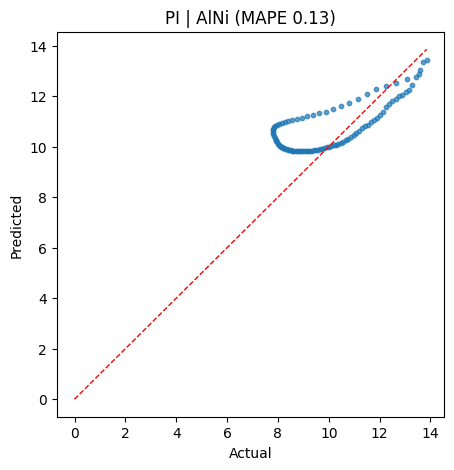

[PI] Left-out: AlNi | Test MAPE: 0.1323
[PI] CuMg | Epoch 10/50  Loss: 3.4455
[PI] CuMg | Epoch 20/50  Loss: 2.9576
[PI] CuMg | Epoch 30/50  Loss: 2.6091
[PI] CuMg | Epoch 40/50  Loss: 2.3514
[PI] CuMg | Epoch 50/50  Loss: 2.3504


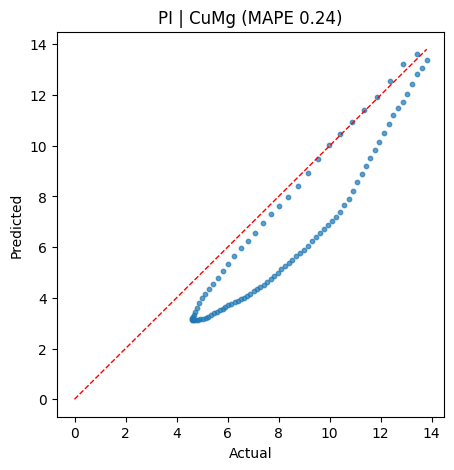

[PI] Left-out: CuMg | Test MAPE: 0.2373
[PI] NiMg | Epoch 10/50  Loss: 3.3778
[PI] NiMg | Epoch 20/50  Loss: 2.8755
[PI] NiMg | Epoch 30/50  Loss: 2.6058
[PI] NiMg | Epoch 40/50  Loss: 2.3785
[PI] NiMg | Epoch 50/50  Loss: 2.3473


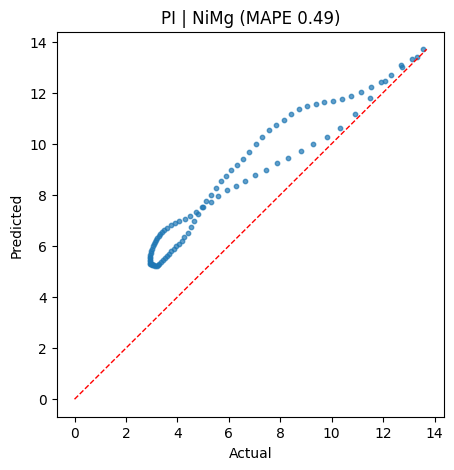

[PI] Left-out: NiMg | Test MAPE: 0.4917
[PI] AlTi | Epoch 10/50  Loss: 3.4796
[PI] AlTi | Epoch 20/50  Loss: 2.9258
[PI] AlTi | Epoch 30/50  Loss: 2.7323
[PI] AlTi | Epoch 40/50  Loss: 2.6496
[PI] AlTi | Epoch 50/50  Loss: 2.2836


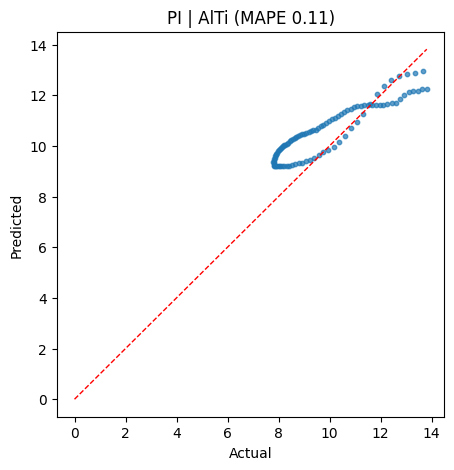

[PI] Left-out: AlTi | Test MAPE: 0.1097
[PI] AlV | Epoch 10/50  Loss: 3.5493
[PI] AlV | Epoch 20/50  Loss: 3.1223
[PI] AlV | Epoch 30/50  Loss: 2.6123
[PI] AlV | Epoch 40/50  Loss: 2.5511
[PI] AlV | Epoch 50/50  Loss: 2.3045


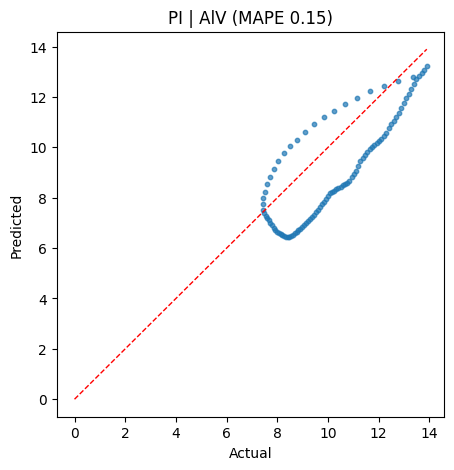

[PI] Left-out: AlV | Test MAPE: 0.1510


KeyboardInterrupt: 

In [14]:
for name, df in [("PI", df_pi), ("EP", df_ep), ("Comp", df_comp), ("Random", df_rand)]:
    mean_mape, mapes, per_sys = run_loop(df, name, epochs=50, batch_size=32, lr=1e-3)
    print(f"{name} mean MAPE: {mean_mape:.4f}")
    #plot_pred_vs_actual(per_sys, n=6)
    #plot_error_hist(per_sys)

[PI] AlNi | Epoch 10/50  Loss: 2.0864
[PI] AlNi | Epoch 20/50  Loss: 1.4840
[PI] AlNi | Epoch 30/50  Loss: 1.0805
[PI] AlNi | Epoch 40/50  Loss: 0.8400
[PI] AlNi | Epoch 50/50  Loss: 0.6538


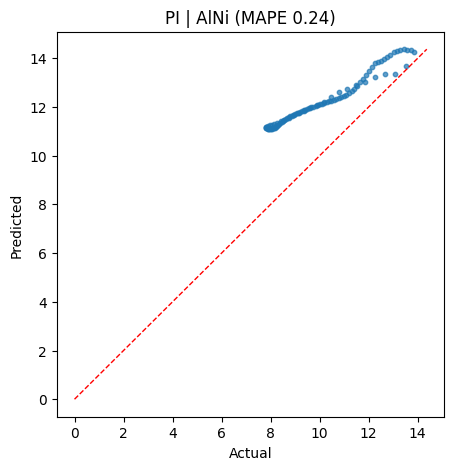

[PI] Left-out: AlNi | Test MAPE: 0.2407
[PI] CuMg | Epoch 10/50  Loss: 1.9668
[PI] CuMg | Epoch 20/50  Loss: 1.5001
[PI] CuMg | Epoch 30/50  Loss: 1.1066
[PI] CuMg | Epoch 40/50  Loss: 0.7748
[PI] CuMg | Epoch 50/50  Loss: 0.6339


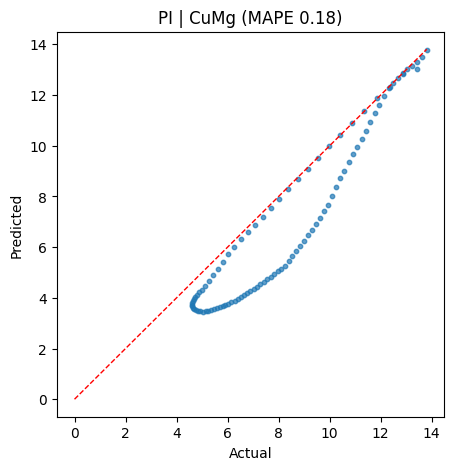

[PI] Left-out: CuMg | Test MAPE: 0.1821
[PI] NiMg | Epoch 10/50  Loss: 1.9424
[PI] NiMg | Epoch 20/50  Loss: 1.3490
[PI] NiMg | Epoch 30/50  Loss: 0.9873
[PI] NiMg | Epoch 40/50  Loss: 0.7373
[PI] NiMg | Epoch 50/50  Loss: 0.5765


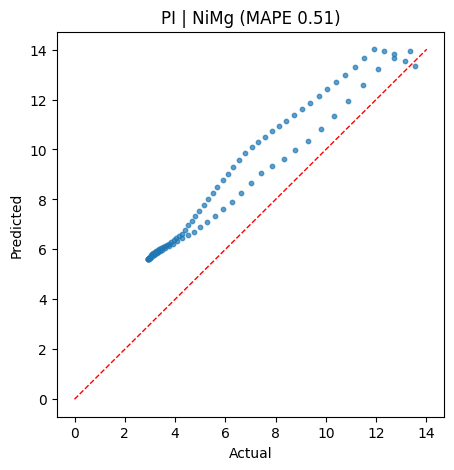

[PI] Left-out: NiMg | Test MAPE: 0.5111
[PI] AlTi | Epoch 10/50  Loss: 2.1320
[PI] AlTi | Epoch 20/50  Loss: 1.5706
[PI] AlTi | Epoch 30/50  Loss: 1.2193
[PI] AlTi | Epoch 40/50  Loss: 0.9463
[PI] AlTi | Epoch 50/50  Loss: 0.7556


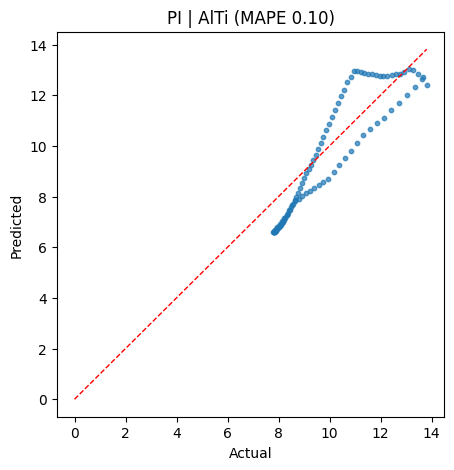

[PI] Left-out: AlTi | Test MAPE: 0.1023
[PI] AlV | Epoch 10/50  Loss: 1.9097
[PI] AlV | Epoch 20/50  Loss: 1.3089
[PI] AlV | Epoch 30/50  Loss: 0.8974
[PI] AlV | Epoch 40/50  Loss: 0.6575
[PI] AlV | Epoch 50/50  Loss: 0.5268


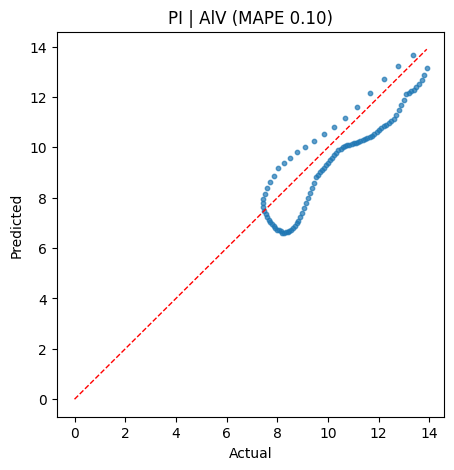

[PI] Left-out: AlV | Test MAPE: 0.1006
[PI] VNi | Epoch 10/50  Loss: 2.1721
[PI] VNi | Epoch 20/50  Loss: 1.4834
[PI] VNi | Epoch 30/50  Loss: 1.0491
[PI] VNi | Epoch 40/50  Loss: 0.7799
[PI] VNi | Epoch 50/50  Loss: 0.6038


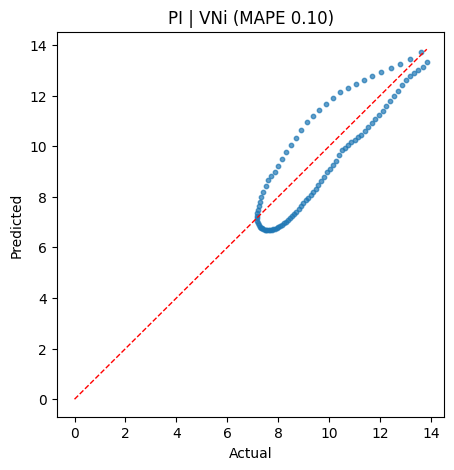

[PI] Left-out: VNi | Test MAPE: 0.1004
[PI] CuSi | Epoch 10/50  Loss: 1.9655
[PI] CuSi | Epoch 20/50  Loss: 1.4357
[PI] CuSi | Epoch 30/50  Loss: 0.9753
[PI] CuSi | Epoch 40/50  Loss: 0.7291
[PI] CuSi | Epoch 50/50  Loss: 0.5693


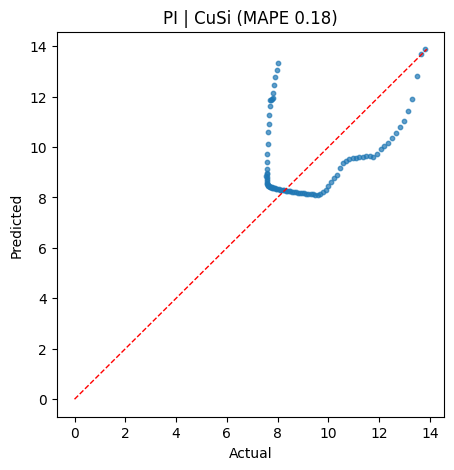

[PI] Left-out: CuSi | Test MAPE: 0.1755
[PI] VSi | Epoch 10/50  Loss: 1.9695
[PI] VSi | Epoch 20/50  Loss: 1.3923
[PI] VSi | Epoch 30/50  Loss: 1.1420
[PI] VSi | Epoch 40/50  Loss: 0.9188
[PI] VSi | Epoch 50/50  Loss: 0.7600


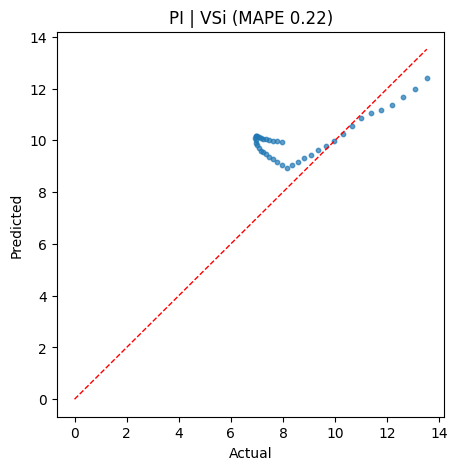

[PI] Left-out: VSi | Test MAPE: 0.2188
[PI] CuZr | Epoch 10/50  Loss: 1.8749
[PI] CuZr | Epoch 20/50  Loss: 1.3232
[PI] CuZr | Epoch 30/50  Loss: 0.9297
[PI] CuZr | Epoch 40/50  Loss: 0.6501
[PI] CuZr | Epoch 50/50  Loss: 0.4954


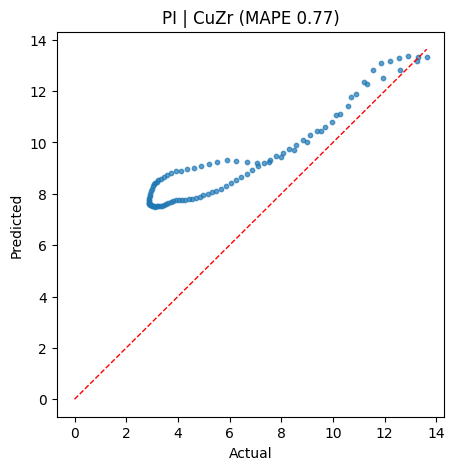

[PI] Left-out: CuZr | Test MAPE: 0.7692
[PI] MoZr | Epoch 10/50  Loss: 2.2215
[PI] MoZr | Epoch 20/50  Loss: 1.4229
[PI] MoZr | Epoch 30/50  Loss: 0.9739
[PI] MoZr | Epoch 40/50  Loss: 0.7887
[PI] MoZr | Epoch 50/50  Loss: 0.6289


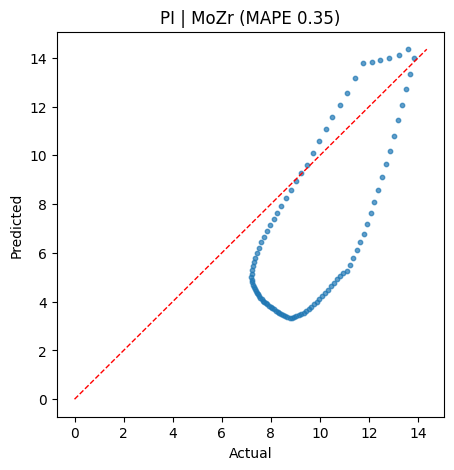

[PI] Left-out: MoZr | Test MAPE: 0.3486
[PI] CoMg | Epoch 10/50  Loss: 1.9175
[PI] CoMg | Epoch 20/50  Loss: 1.3055
[PI] CoMg | Epoch 30/50  Loss: 0.8896
[PI] CoMg | Epoch 40/50  Loss: 0.5892
[PI] CoMg | Epoch 50/50  Loss: 0.4492


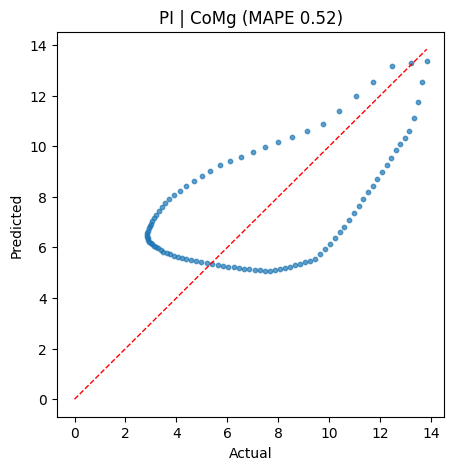

[PI] Left-out: CoMg | Test MAPE: 0.5186
[PI] CrMg | Epoch 10/50  Loss: 2.2752
[PI] CrMg | Epoch 20/50  Loss: 1.5693
[PI] CrMg | Epoch 30/50  Loss: 1.1334
[PI] CrMg | Epoch 40/50  Loss: 0.8526
[PI] CrMg | Epoch 50/50  Loss: 0.7313


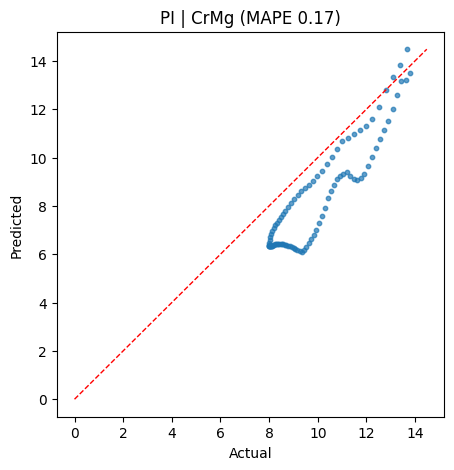

[PI] Left-out: CrMg | Test MAPE: 0.1692
[PI] CrCo | Epoch 10/50  Loss: 1.9612
[PI] CrCo | Epoch 20/50  Loss: 1.3978
[PI] CrCo | Epoch 30/50  Loss: 0.9994
[PI] CrCo | Epoch 40/50  Loss: 0.7184
[PI] CrCo | Epoch 50/50  Loss: 0.5667


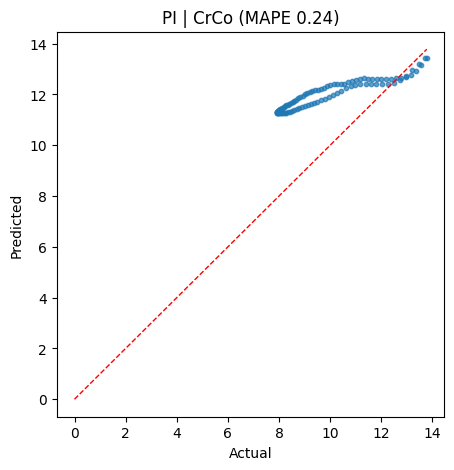

[PI] Left-out: CrCo | Test MAPE: 0.2421
[PI] PdMg | Epoch 10/50  Loss: 2.1667
[PI] PdMg | Epoch 20/50  Loss: 1.3837
[PI] PdMg | Epoch 30/50  Loss: 0.9389
[PI] PdMg | Epoch 40/50  Loss: 0.7267
[PI] PdMg | Epoch 50/50  Loss: 0.5902


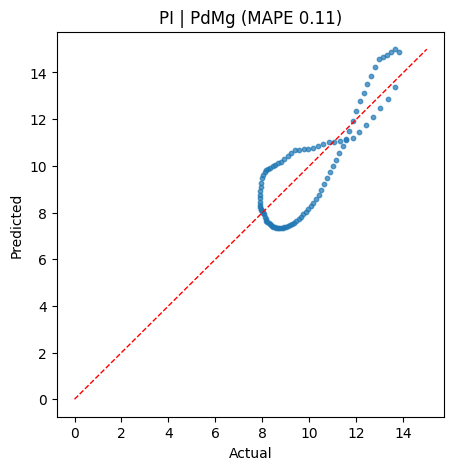

[PI] Left-out: PdMg | Test MAPE: 0.1078
[PI] VY | Epoch 10/50  Loss: 2.0609
[PI] VY | Epoch 20/50  Loss: 1.4867
[PI] VY | Epoch 30/50  Loss: 1.2023
[PI] VY | Epoch 40/50  Loss: 1.0095
[PI] VY | Epoch 50/50  Loss: 0.8294


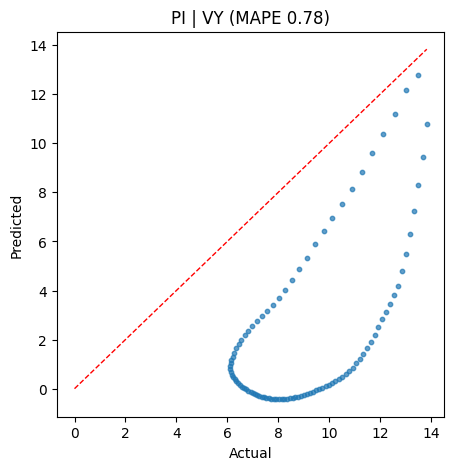

[PI] Left-out: VY | Test MAPE: 0.7777
[PI] VHf | Epoch 10/50  Loss: 1.9458
[PI] VHf | Epoch 20/50  Loss: 1.2894
[PI] VHf | Epoch 30/50  Loss: 0.9576
[PI] VHf | Epoch 40/50  Loss: 0.7083
[PI] VHf | Epoch 50/50  Loss: 0.5222


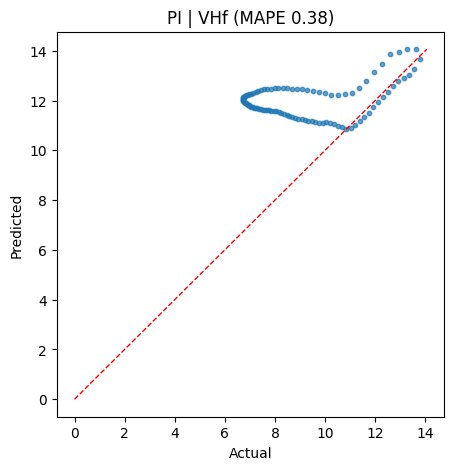

[PI] Left-out: VHf | Test MAPE: 0.3751
[PI] VMg | Epoch 10/50  Loss: 2.1243
[PI] VMg | Epoch 20/50  Loss: 1.4949
[PI] VMg | Epoch 30/50  Loss: 1.1987
[PI] VMg | Epoch 40/50  Loss: 0.9418
[PI] VMg | Epoch 50/50  Loss: 0.7126


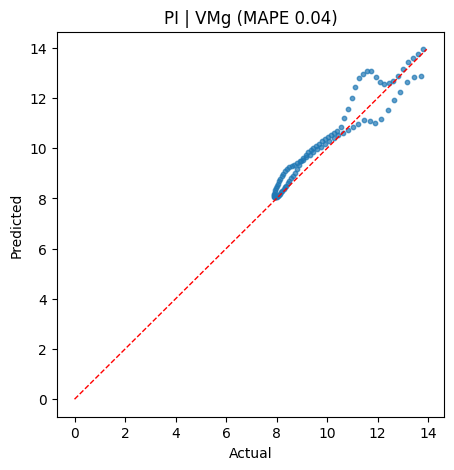

[PI] Left-out: VMg | Test MAPE: 0.0444
[PI] MnMg | Epoch 10/50  Loss: 1.9594
[PI] MnMg | Epoch 20/50  Loss: 1.2148
[PI] MnMg | Epoch 30/50  Loss: 0.8316
[PI] MnMg | Epoch 40/50  Loss: 0.6454
[PI] MnMg | Epoch 50/50  Loss: 0.5193


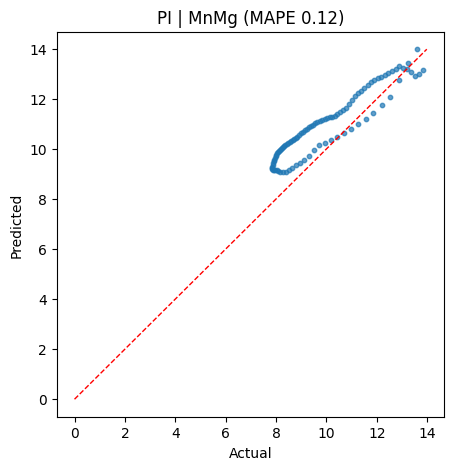

[PI] Left-out: MnMg | Test MAPE: 0.1155
[PI] TaMn | Epoch 10/50  Loss: 1.6482
[PI] TaMn | Epoch 20/50  Loss: 1.0771
[PI] TaMn | Epoch 30/50  Loss: 0.7983
[PI] TaMn | Epoch 40/50  Loss: 0.6536
[PI] TaMn | Epoch 50/50  Loss: 0.5561


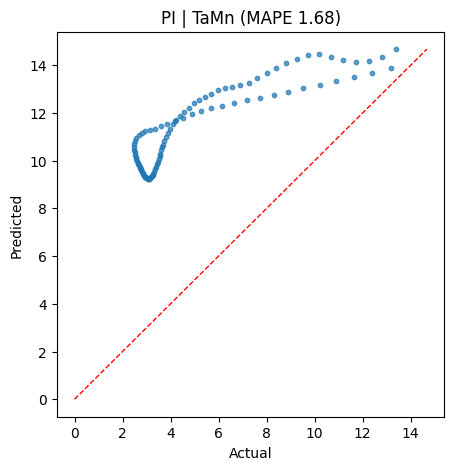

[PI] Left-out: TaMn | Test MAPE: 1.6766
[PI] GeMg | Epoch 10/50  Loss: 1.9502
[PI] GeMg | Epoch 20/50  Loss: 1.4143
[PI] GeMg | Epoch 30/50  Loss: 1.0130
[PI] GeMg | Epoch 40/50  Loss: 0.7311
[PI] GeMg | Epoch 50/50  Loss: 0.5894


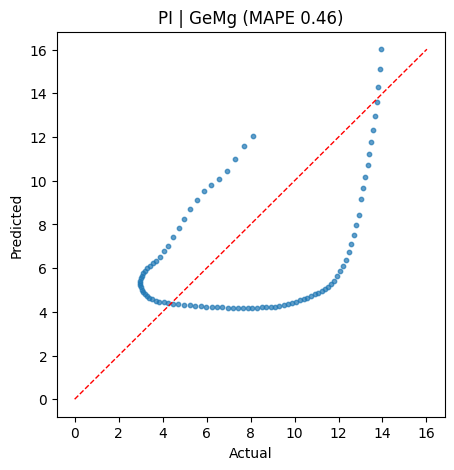

[PI] Left-out: GeMg | Test MAPE: 0.4633
[PI] PtMg | Epoch 10/50  Loss: 2.0703
[PI] PtMg | Epoch 20/50  Loss: 1.4610
[PI] PtMg | Epoch 30/50  Loss: 1.0483
[PI] PtMg | Epoch 40/50  Loss: 0.7397
[PI] PtMg | Epoch 50/50  Loss: 0.5864


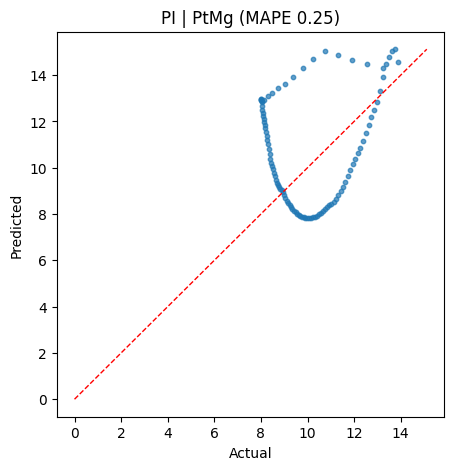

[PI] Left-out: PtMg | Test MAPE: 0.2458
[PI] PtGe | Epoch 10/50  Loss: 1.9349
[PI] PtGe | Epoch 20/50  Loss: 1.3663
[PI] PtGe | Epoch 30/50  Loss: 1.0754
[PI] PtGe | Epoch 40/50  Loss: 0.8710
[PI] PtGe | Epoch 50/50  Loss: 0.7479


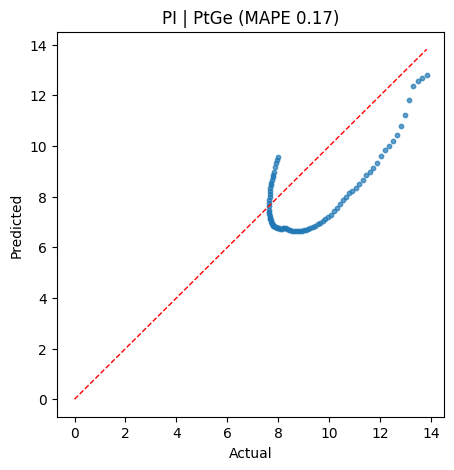

[PI] Left-out: PtGe | Test MAPE: 0.1691
[PI] WMg | Epoch 10/50  Loss: 2.0030
[PI] WMg | Epoch 20/50  Loss: 1.3515
[PI] WMg | Epoch 30/50  Loss: 0.9689
[PI] WMg | Epoch 40/50  Loss: 0.7479
[PI] WMg | Epoch 50/50  Loss: 0.6053


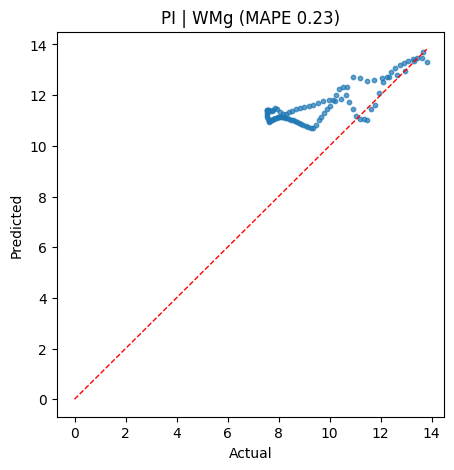

[PI] Left-out: WMg | Test MAPE: 0.2326
[PI] AuHf | Epoch 10/50  Loss: 1.8611
[PI] AuHf | Epoch 20/50  Loss: 1.2617
[PI] AuHf | Epoch 30/50  Loss: 0.9106
[PI] AuHf | Epoch 40/50  Loss: 0.7018
[PI] AuHf | Epoch 50/50  Loss: 0.5455


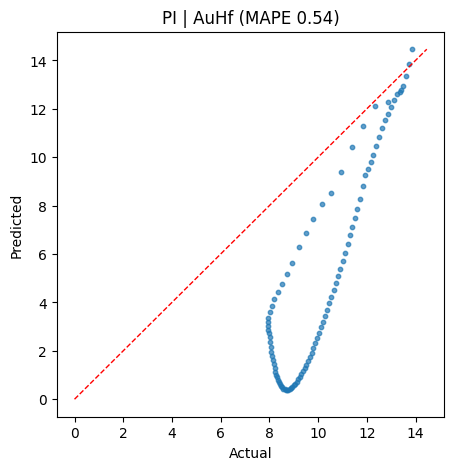

[PI] Left-out: AuHf | Test MAPE: 0.5422
[PI] CrAl | Epoch 10/50  Loss: 2.0077
[PI] CrAl | Epoch 20/50  Loss: 1.4224
[PI] CrAl | Epoch 30/50  Loss: 1.0511
[PI] CrAl | Epoch 40/50  Loss: 0.7579
[PI] CrAl | Epoch 50/50  Loss: 0.5689


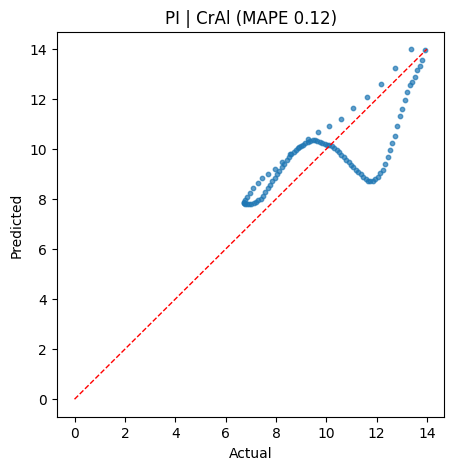

[PI] Left-out: CrAl | Test MAPE: 0.1235
[PI] MnAl | Epoch 10/50  Loss: 2.0446
[PI] MnAl | Epoch 20/50  Loss: 1.5839
[PI] MnAl | Epoch 30/50  Loss: 1.2784
[PI] MnAl | Epoch 40/50  Loss: 1.0174
[PI] MnAl | Epoch 50/50  Loss: 0.8615


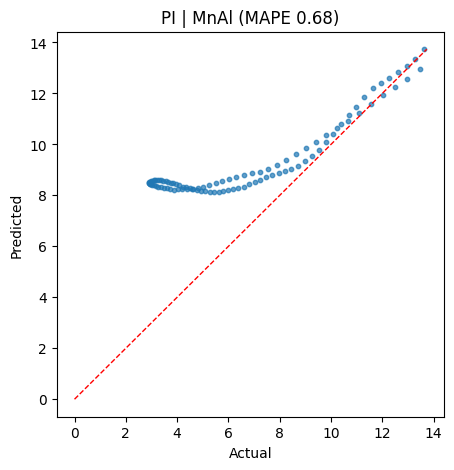

[PI] Left-out: MnAl | Test MAPE: 0.6782
[PI] FeAl | Epoch 10/50  Loss: 2.0798
[PI] FeAl | Epoch 20/50  Loss: 1.4662
[PI] FeAl | Epoch 30/50  Loss: 1.1278
[PI] FeAl | Epoch 40/50  Loss: 0.9155
[PI] FeAl | Epoch 50/50  Loss: 0.7741


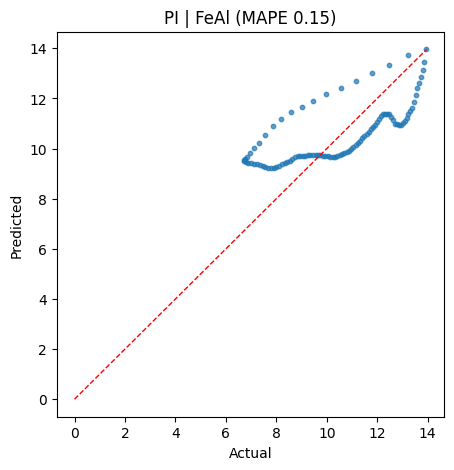

[PI] Left-out: FeAl | Test MAPE: 0.1480
[PI] HfAl | Epoch 10/50  Loss: 1.8884
[PI] HfAl | Epoch 20/50  Loss: 1.3559
[PI] HfAl | Epoch 30/50  Loss: 1.0244
[PI] HfAl | Epoch 40/50  Loss: 0.8124
[PI] HfAl | Epoch 50/50  Loss: 0.6319


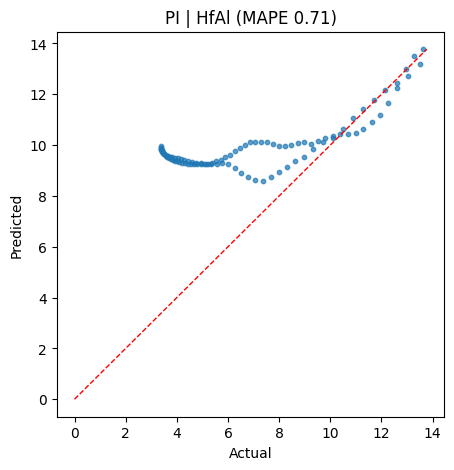

[PI] Left-out: HfAl | Test MAPE: 0.7136
[PI] HfFe | Epoch 10/50  Loss: 1.8287
[PI] HfFe | Epoch 20/50  Loss: 1.0619
[PI] HfFe | Epoch 30/50  Loss: 0.8114
[PI] HfFe | Epoch 40/50  Loss: 0.7164
[PI] HfFe | Epoch 50/50  Loss: 0.6212


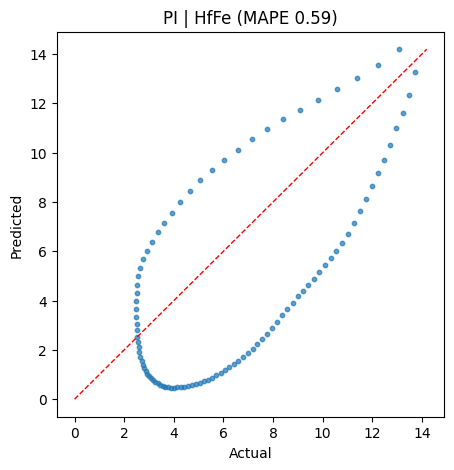

[PI] Left-out: HfFe | Test MAPE: 0.5876
[PI] CuAl | Epoch 10/50  Loss: 1.8111
[PI] CuAl | Epoch 20/50  Loss: 1.2393
[PI] CuAl | Epoch 30/50  Loss: 0.9604
[PI] CuAl | Epoch 40/50  Loss: 0.8010
[PI] CuAl | Epoch 50/50  Loss: 0.6702


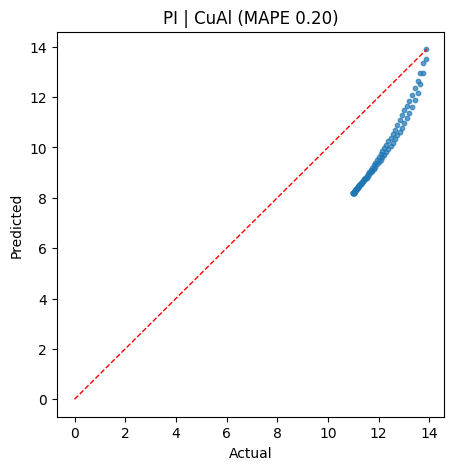

[PI] Left-out: CuAl | Test MAPE: 0.1990
[PI] CuNi | Epoch 10/50  Loss: 2.1888
[PI] CuNi | Epoch 20/50  Loss: 1.6563
[PI] CuNi | Epoch 30/50  Loss: 1.3649
[PI] CuNi | Epoch 40/50  Loss: 1.1665
[PI] CuNi | Epoch 50/50  Loss: 1.0407


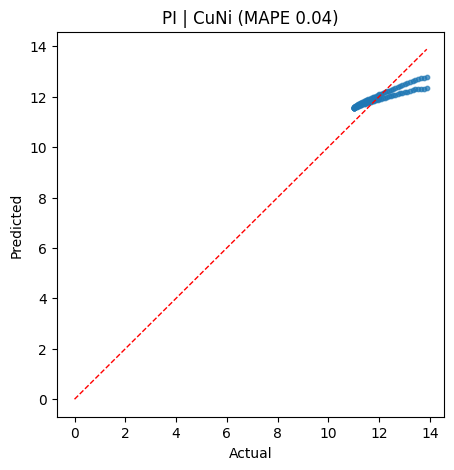

[PI] Left-out: CuNi | Test MAPE: 0.0395
[PI] AlMg | Epoch 10/50  Loss: 2.1097
[PI] AlMg | Epoch 20/50  Loss: 1.5259
[PI] AlMg | Epoch 30/50  Loss: 1.0186
[PI] AlMg | Epoch 40/50  Loss: 0.7330
[PI] AlMg | Epoch 50/50  Loss: 0.5767


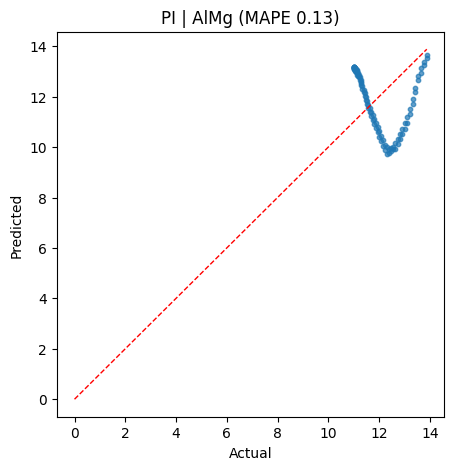

[PI] Left-out: AlMg | Test MAPE: 0.1298
[PI] VTi | Epoch 10/50  Loss: 2.0397
[PI] VTi | Epoch 20/50  Loss: 1.3414
[PI] VTi | Epoch 30/50  Loss: 0.9831
[PI] VTi | Epoch 40/50  Loss: 0.7389
[PI] VTi | Epoch 50/50  Loss: 0.5812


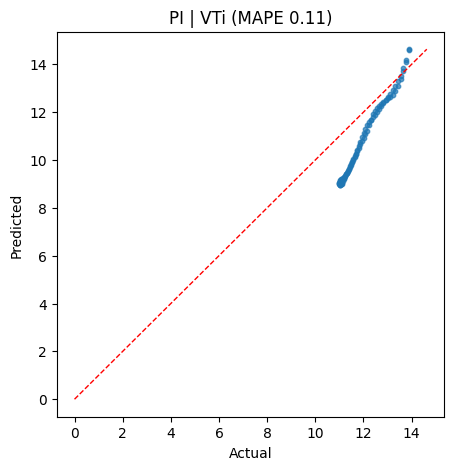

[PI] Left-out: VTi | Test MAPE: 0.1064
[PI] CrNi | Epoch 10/50  Loss: 2.1680
[PI] CrNi | Epoch 20/50  Loss: 1.5159
[PI] CrNi | Epoch 30/50  Loss: 1.1618
[PI] CrNi | Epoch 40/50  Loss: 0.9181
[PI] CrNi | Epoch 50/50  Loss: 0.7522


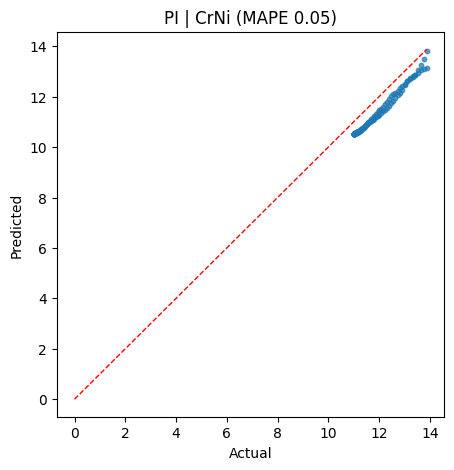

[PI] Left-out: CrNi | Test MAPE: 0.0475
[PI] CrV | Epoch 10/50  Loss: 1.9669
[PI] CrV | Epoch 20/50  Loss: 1.3602
[PI] CrV | Epoch 30/50  Loss: 1.0383
[PI] CrV | Epoch 40/50  Loss: 0.8285
[PI] CrV | Epoch 50/50  Loss: 0.6510


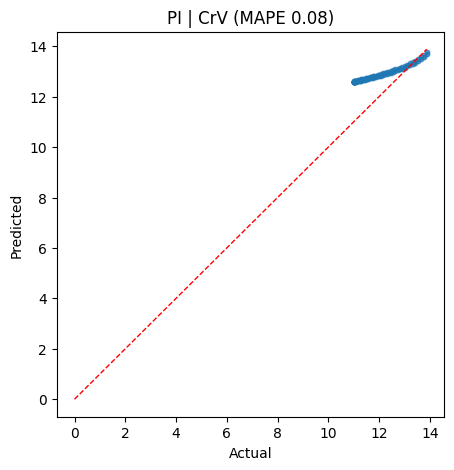

[PI] Left-out: CrV | Test MAPE: 0.0808
[PI] VCu | Epoch 10/50  Loss: 2.3378
[PI] VCu | Epoch 20/50  Loss: 1.8298
[PI] VCu | Epoch 30/50  Loss: 1.3345
[PI] VCu | Epoch 40/50  Loss: 0.9454
[PI] VCu | Epoch 50/50  Loss: 0.7244


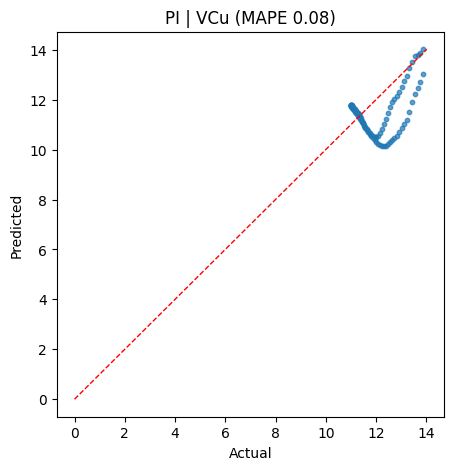

[PI] Left-out: VCu | Test MAPE: 0.0751
[PI] MoCu | Epoch 10/50  Loss: 2.0317
[PI] MoCu | Epoch 20/50  Loss: 1.2717
[PI] MoCu | Epoch 30/50  Loss: 0.8265
[PI] MoCu | Epoch 40/50  Loss: 0.5995
[PI] MoCu | Epoch 50/50  Loss: 0.4737


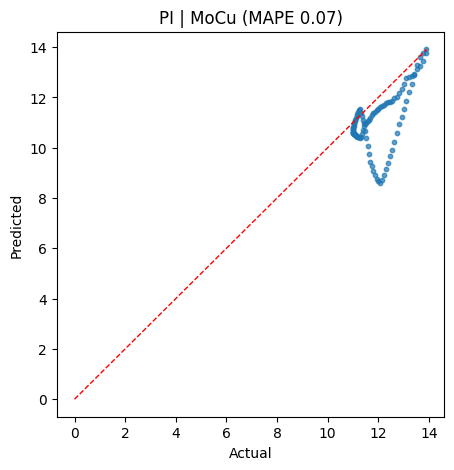

[PI] Left-out: MoCu | Test MAPE: 0.0737
[PI] TiZr | Epoch 10/50  Loss: 1.9167
[PI] TiZr | Epoch 20/50  Loss: 1.3218
[PI] TiZr | Epoch 30/50  Loss: 0.9976
[PI] TiZr | Epoch 40/50  Loss: 0.8146
[PI] TiZr | Epoch 50/50  Loss: 0.6692


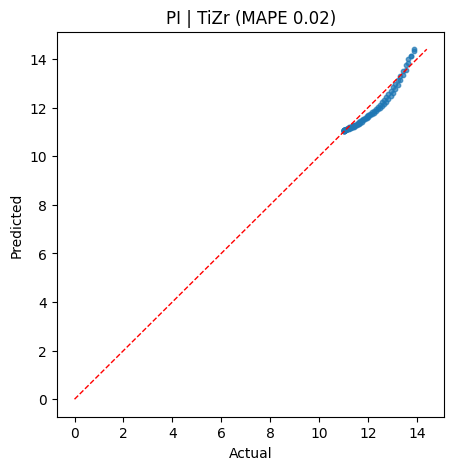

[PI] Left-out: TiZr | Test MAPE: 0.0172
[PI] HfZr | Epoch 10/50  Loss: 2.0260
[PI] HfZr | Epoch 20/50  Loss: 1.5421
[PI] HfZr | Epoch 30/50  Loss: 1.1968
[PI] HfZr | Epoch 40/50  Loss: 0.9653
[PI] HfZr | Epoch 50/50  Loss: 0.8020


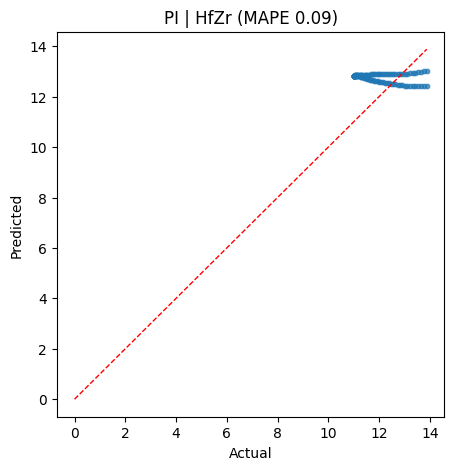

[PI] Left-out: HfZr | Test MAPE: 0.0934
[PI] HfTi | Epoch 10/50  Loss: 1.9330
[PI] HfTi | Epoch 20/50  Loss: 1.4526
[PI] HfTi | Epoch 30/50  Loss: 1.1026
[PI] HfTi | Epoch 40/50  Loss: 0.9023
[PI] HfTi | Epoch 50/50  Loss: 0.7767


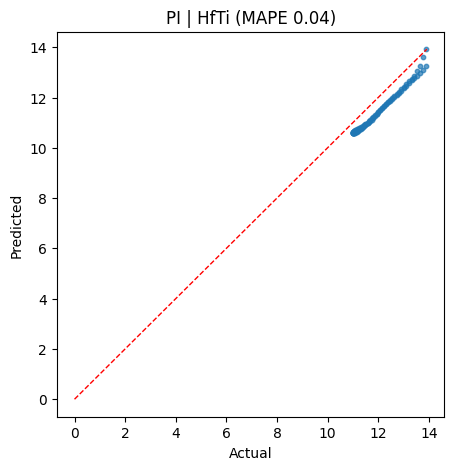

[PI] Left-out: HfTi | Test MAPE: 0.0442
[PI] TiMg | Epoch 10/50  Loss: 1.9866
[PI] TiMg | Epoch 20/50  Loss: 1.3181
[PI] TiMg | Epoch 30/50  Loss: 0.9680
[PI] TiMg | Epoch 40/50  Loss: 0.7864
[PI] TiMg | Epoch 50/50  Loss: 0.6157


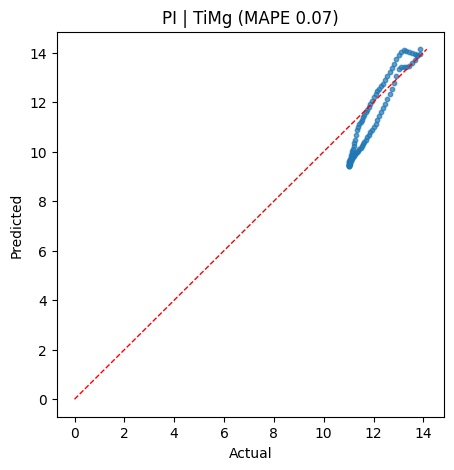

[PI] Left-out: TiMg | Test MAPE: 0.0699
[PI] MoMg | Epoch 10/50  Loss: 1.9387
[PI] MoMg | Epoch 20/50  Loss: 1.1801
[PI] MoMg | Epoch 30/50  Loss: 0.8504
[PI] MoMg | Epoch 40/50  Loss: 0.6708
[PI] MoMg | Epoch 50/50  Loss: 0.5666


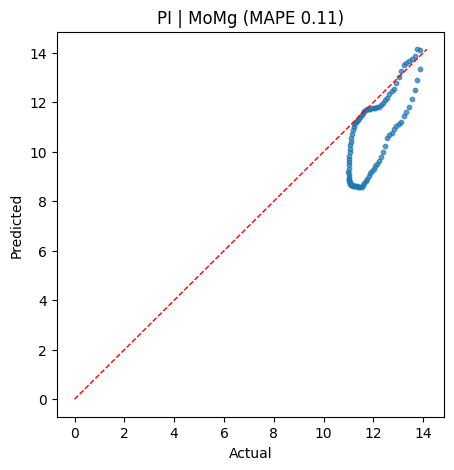

[PI] Left-out: MoMg | Test MAPE: 0.1146
[PI] MoTi | Epoch 10/50  Loss: 2.2826
[PI] MoTi | Epoch 20/50  Loss: 1.6718
[PI] MoTi | Epoch 30/50  Loss: 1.3220
[PI] MoTi | Epoch 40/50  Loss: 1.0402
[PI] MoTi | Epoch 50/50  Loss: 0.9035


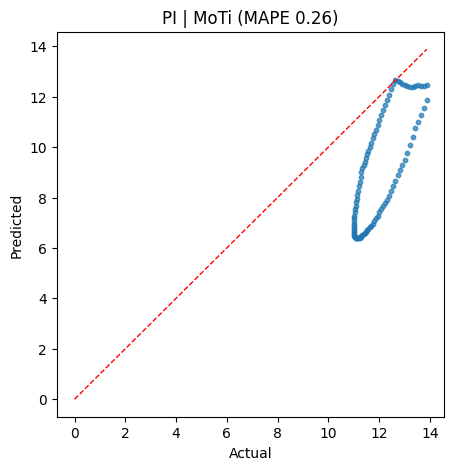

[PI] Left-out: MoTi | Test MAPE: 0.2573
[PI] PdFe | Epoch 10/50  Loss: 2.1753
[PI] PdFe | Epoch 20/50  Loss: 1.6151
[PI] PdFe | Epoch 30/50  Loss: 1.1321
[PI] PdFe | Epoch 40/50  Loss: 0.8515
[PI] PdFe | Epoch 50/50  Loss: 0.7219


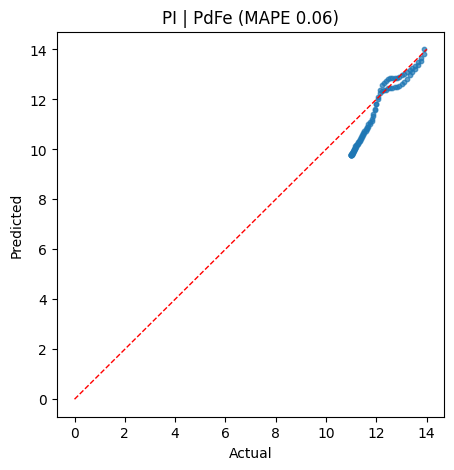

[PI] Left-out: PdFe | Test MAPE: 0.0564
[PI] HfY | Epoch 10/50  Loss: 2.0311
[PI] HfY | Epoch 20/50  Loss: 1.3686
[PI] HfY | Epoch 30/50  Loss: 0.9609
[PI] HfY | Epoch 40/50  Loss: 0.7608
[PI] HfY | Epoch 50/50  Loss: 0.5960


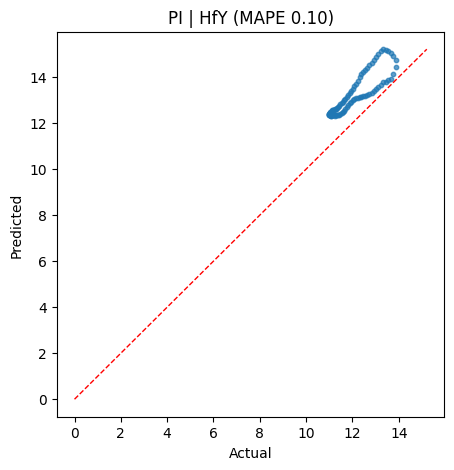

[PI] Left-out: HfY | Test MAPE: 0.1006
[PI] SnMg | Epoch 10/50  Loss: 1.9914
[PI] SnMg | Epoch 20/50  Loss: 1.4463
[PI] SnMg | Epoch 30/50  Loss: 1.1567
[PI] SnMg | Epoch 40/50  Loss: 0.9180
[PI] SnMg | Epoch 50/50  Loss: 0.7146


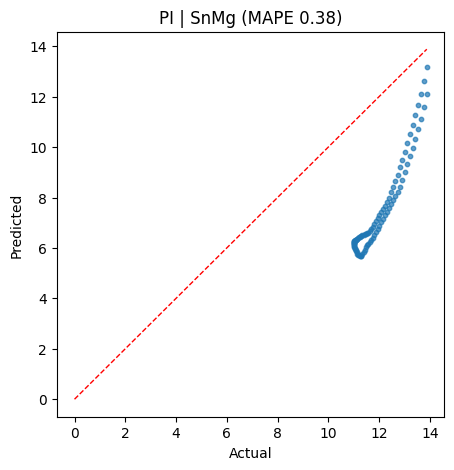

[PI] Left-out: SnMg | Test MAPE: 0.3795
[PI] VSn | Epoch 10/50  Loss: 1.9402
[PI] VSn | Epoch 20/50  Loss: 1.4447
[PI] VSn | Epoch 30/50  Loss: 1.0919
[PI] VSn | Epoch 40/50  Loss: 0.8541
[PI] VSn | Epoch 50/50  Loss: 0.6902


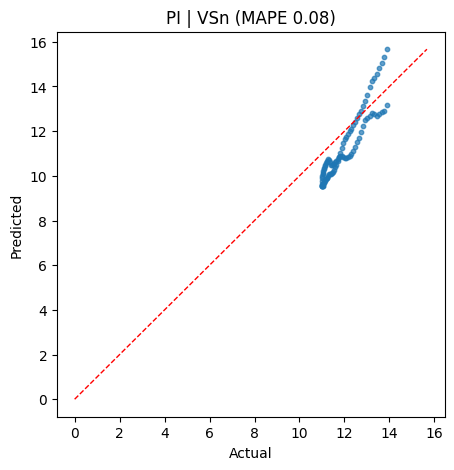

[PI] Left-out: VSn | Test MAPE: 0.0792
[PI] TaMg | Epoch 10/50  Loss: 1.9482
[PI] TaMg | Epoch 20/50  Loss: 1.3704
[PI] TaMg | Epoch 30/50  Loss: 1.0743
[PI] TaMg | Epoch 40/50  Loss: 0.8269
[PI] TaMg | Epoch 50/50  Loss: 0.6328


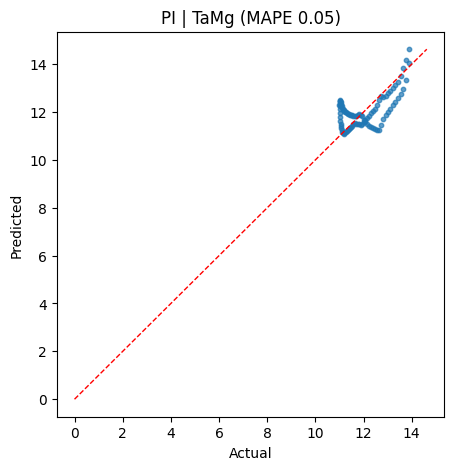

[PI] Left-out: TaMg | Test MAPE: 0.0476
[PI] NbMg | Epoch 10/50  Loss: 2.0880
[PI] NbMg | Epoch 20/50  Loss: 1.4649
[PI] NbMg | Epoch 30/50  Loss: 1.0742
[PI] NbMg | Epoch 40/50  Loss: 0.7598
[PI] NbMg | Epoch 50/50  Loss: 0.5799


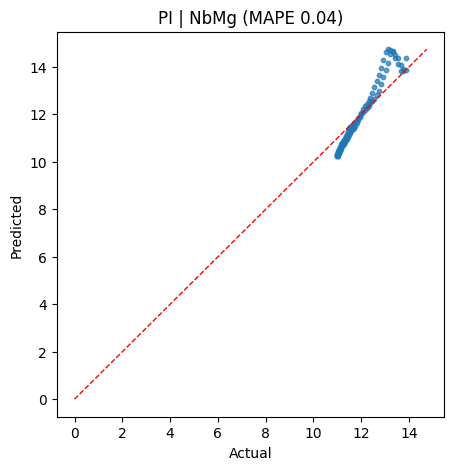

[PI] Left-out: NbMg | Test MAPE: 0.0398
[PI] WNb | Epoch 10/50  Loss: 1.9962
[PI] WNb | Epoch 20/50  Loss: 1.2500
[PI] WNb | Epoch 30/50  Loss: 0.7669
[PI] WNb | Epoch 40/50  Loss: 0.5738
[PI] WNb | Epoch 50/50  Loss: 0.4624


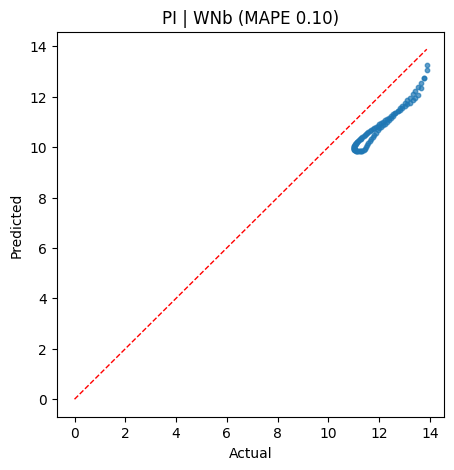

[PI] Left-out: WNb | Test MAPE: 0.0995
[PI] HfMg | Epoch 10/50  Loss: 2.1140
[PI] HfMg | Epoch 20/50  Loss: 1.5687
[PI] HfMg | Epoch 30/50  Loss: 1.1997
[PI] HfMg | Epoch 40/50  Loss: 0.9520
[PI] HfMg | Epoch 50/50  Loss: 0.7772


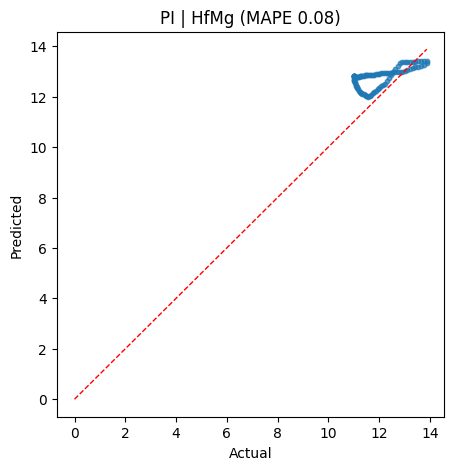

[PI] Left-out: HfMg | Test MAPE: 0.0758
[PI] AuMg | Epoch 10/50  Loss: 1.8868
[PI] AuMg | Epoch 20/50  Loss: 1.3790
[PI] AuMg | Epoch 30/50  Loss: 1.0207
[PI] AuMg | Epoch 40/50  Loss: 0.7640
[PI] AuMg | Epoch 50/50  Loss: 0.6225


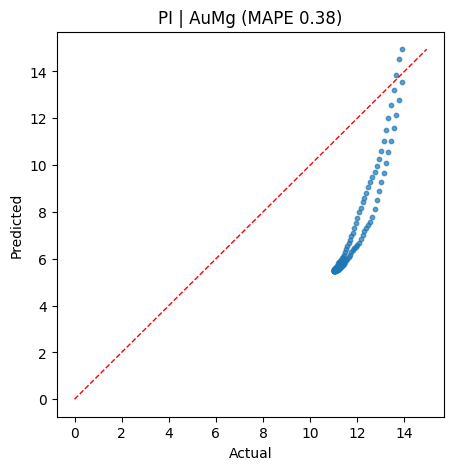

[PI] Left-out: AuMg | Test MAPE: 0.3813
[PI] AuAl | Epoch 10/50  Loss: 2.1809
[PI] AuAl | Epoch 20/50  Loss: 1.6436
[PI] AuAl | Epoch 30/50  Loss: 1.2501
[PI] AuAl | Epoch 40/50  Loss: 1.0090
[PI] AuAl | Epoch 50/50  Loss: 0.8441


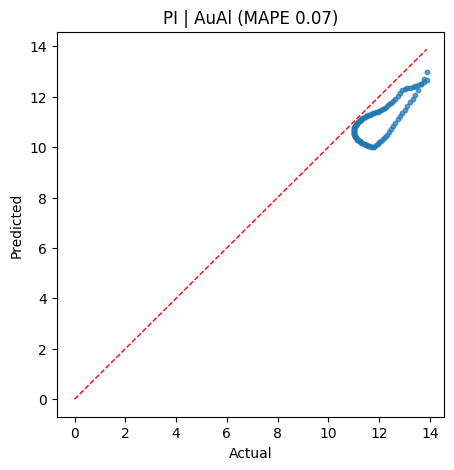

[PI] Left-out: AuAl | Test MAPE: 0.0730
[PI] AuCr | Epoch 10/50  Loss: 2.0142
[PI] AuCr | Epoch 20/50  Loss: 1.2415
[PI] AuCr | Epoch 30/50  Loss: 0.8875
[PI] AuCr | Epoch 40/50  Loss: 0.7306
[PI] AuCr | Epoch 50/50  Loss: 0.6195


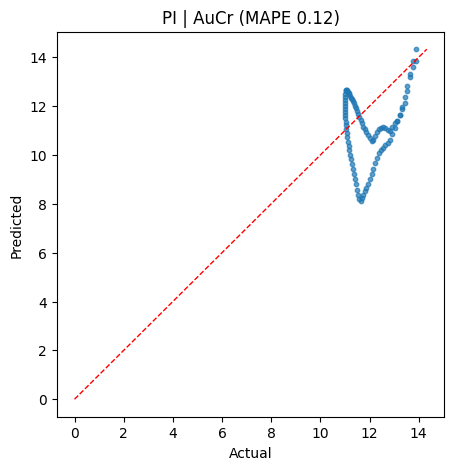

[PI] Left-out: AuCr | Test MAPE: 0.1214
[PI] AgAl | Epoch 10/50  Loss: 1.9647
[PI] AgAl | Epoch 20/50  Loss: 1.2598
[PI] AgAl | Epoch 30/50  Loss: 0.8350
[PI] AgAl | Epoch 40/50  Loss: 0.6328
[PI] AgAl | Epoch 50/50  Loss: 0.5122


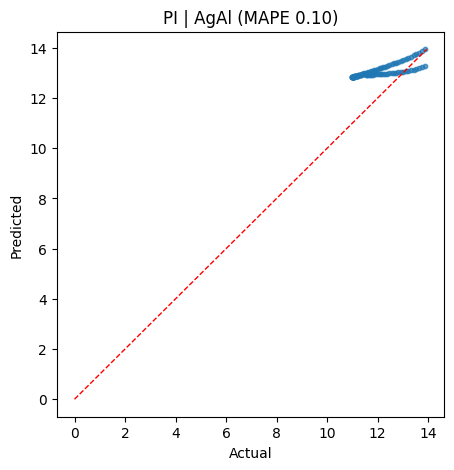

[PI] Left-out: AgAl | Test MAPE: 0.0991
[PI] MnAg | Epoch 10/50  Loss: 1.8416
[PI] MnAg | Epoch 20/50  Loss: 1.1720
[PI] MnAg | Epoch 30/50  Loss: 0.7975
[PI] MnAg | Epoch 40/50  Loss: 0.6301
[PI] MnAg | Epoch 50/50  Loss: 0.5039


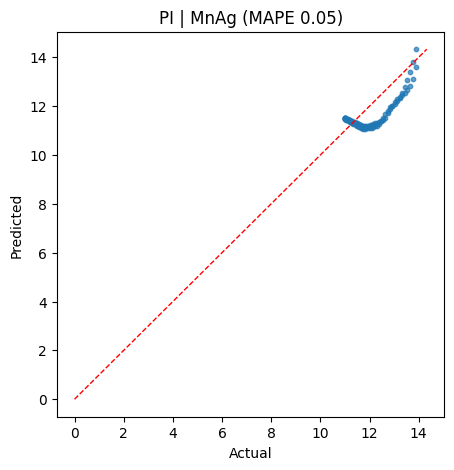

[PI] Left-out: MnAg | Test MAPE: 0.0472
[PI] PdSi | Epoch 10/50  Loss: 1.9404
[PI] PdSi | Epoch 20/50  Loss: 1.3580
[PI] PdSi | Epoch 30/50  Loss: 1.0735
[PI] PdSi | Epoch 40/50  Loss: 0.8493
[PI] PdSi | Epoch 50/50  Loss: 0.7170


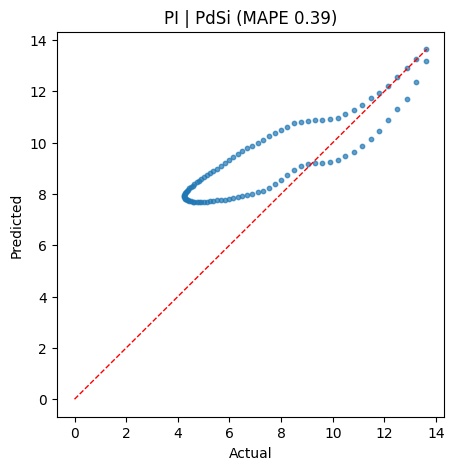

[PI] Left-out: PdSi | Test MAPE: 0.3876


In [10]:
pi_mean_mape, pi_mapes, pi_per_sys = run_loop(df_pi, "PI", epochs=50, batch_size=32, lr=1e-3)

[EP] AlNi | Epoch 10/50  Loss: 2.6724
[EP] AlNi | Epoch 20/50  Loss: 2.3195
[EP] AlNi | Epoch 30/50  Loss: 2.0241
[EP] AlNi | Epoch 40/50  Loss: 1.8335
[EP] AlNi | Epoch 50/50  Loss: 1.8153


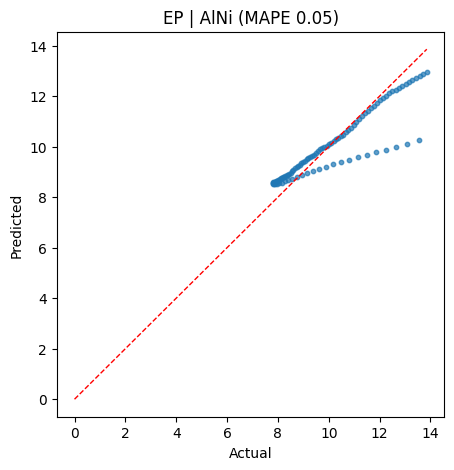

[EP] Left-out: AlNi | Test MAPE: 0.0550
[EP] CuMg | Epoch 10/50  Loss: 2.7981
[EP] CuMg | Epoch 20/50  Loss: 2.1375
[EP] CuMg | Epoch 30/50  Loss: 2.0313
[EP] CuMg | Epoch 40/50  Loss: 1.8241
[EP] CuMg | Epoch 50/50  Loss: 1.6347


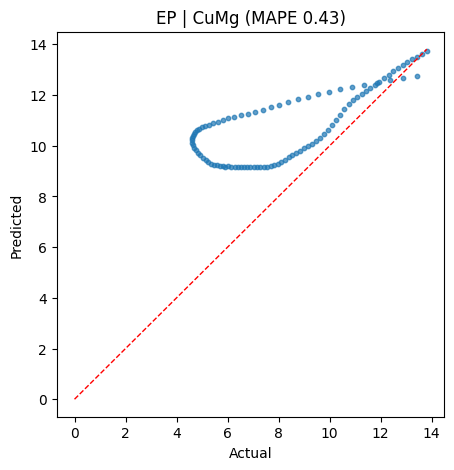

[EP] Left-out: CuMg | Test MAPE: 0.4279
[EP] NiMg | Epoch 10/50  Loss: 2.6939
[EP] NiMg | Epoch 20/50  Loss: 2.1916
[EP] NiMg | Epoch 30/50  Loss: 1.9399
[EP] NiMg | Epoch 40/50  Loss: 1.8456
[EP] NiMg | Epoch 50/50  Loss: 1.7448


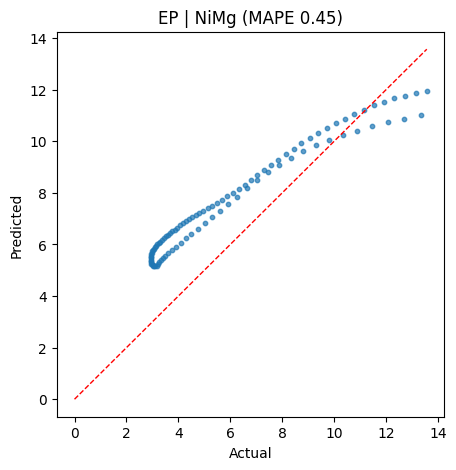

[EP] Left-out: NiMg | Test MAPE: 0.4486
[EP] AlTi | Epoch 10/50  Loss: 2.4775
[EP] AlTi | Epoch 20/50  Loss: 2.1147
[EP] AlTi | Epoch 30/50  Loss: 1.9917
[EP] AlTi | Epoch 40/50  Loss: 1.7601
[EP] AlTi | Epoch 50/50  Loss: 1.6813


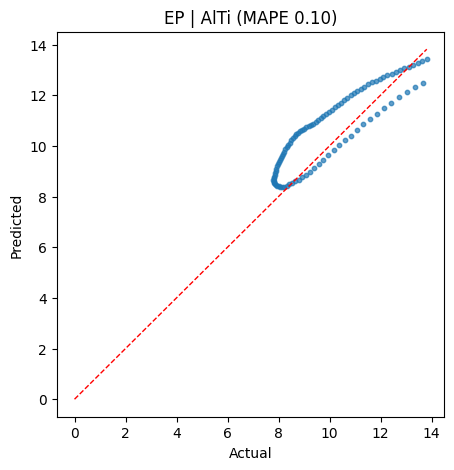

[EP] Left-out: AlTi | Test MAPE: 0.0968
[EP] AlV | Epoch 10/50  Loss: 2.5932
[EP] AlV | Epoch 20/50  Loss: 2.2422
[EP] AlV | Epoch 30/50  Loss: 1.9827
[EP] AlV | Epoch 40/50  Loss: 1.7644
[EP] AlV | Epoch 50/50  Loss: 1.7523


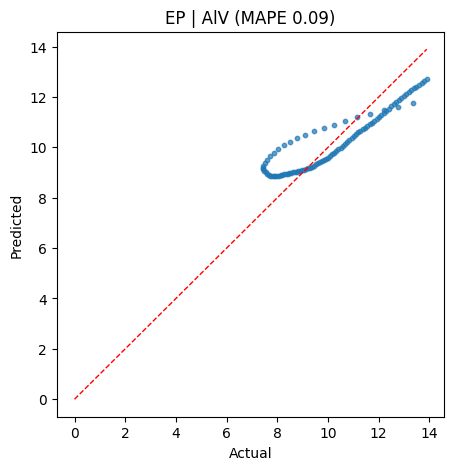

[EP] Left-out: AlV | Test MAPE: 0.0850
[EP] VNi | Epoch 10/50  Loss: 2.7073
[EP] VNi | Epoch 20/50  Loss: 2.2087
[EP] VNi | Epoch 30/50  Loss: 1.8743
[EP] VNi | Epoch 40/50  Loss: 1.7586
[EP] VNi | Epoch 50/50  Loss: 1.6898


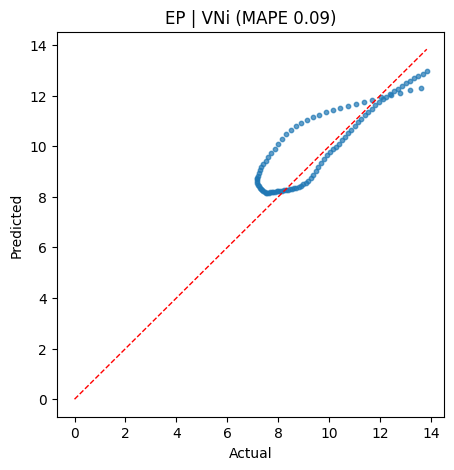

[EP] Left-out: VNi | Test MAPE: 0.0904
[EP] CuSi | Epoch 10/50  Loss: 2.6347
[EP] CuSi | Epoch 20/50  Loss: 2.1908
[EP] CuSi | Epoch 30/50  Loss: 2.0246
[EP] CuSi | Epoch 40/50  Loss: 1.7657
[EP] CuSi | Epoch 50/50  Loss: 1.6363


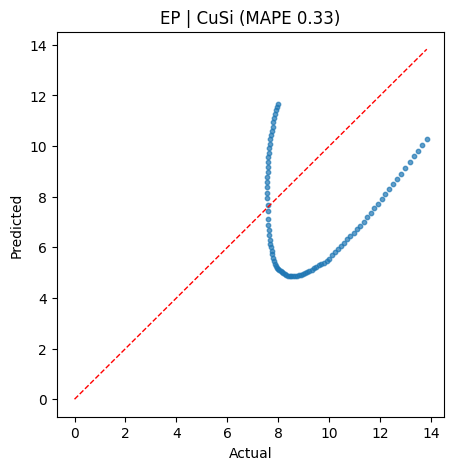

[EP] Left-out: CuSi | Test MAPE: 0.3328
[EP] VSi | Epoch 10/50  Loss: 2.5787
[EP] VSi | Epoch 20/50  Loss: 2.2032
[EP] VSi | Epoch 30/50  Loss: 1.9874
[EP] VSi | Epoch 40/50  Loss: 1.7653


KeyboardInterrupt: 

In [15]:
ep_mean_mape, ep_mapes, ep_per_sys = run_loop(df_ep, "EP", epochs=50, batch_size=32, lr=1e-3)

[Comp] AlNi | Epoch 10/100  Loss: 2.0163
[Comp] AlNi | Epoch 20/100  Loss: 0.6898
[Comp] AlNi | Epoch 30/100  Loss: 0.3108
[Comp] AlNi | Epoch 40/100  Loss: 0.1668
[Comp] AlNi | Epoch 50/100  Loss: 0.0941
[Comp] AlNi | Epoch 60/100  Loss: 0.0555
[Comp] AlNi | Epoch 70/100  Loss: 0.0347
[Comp] AlNi | Epoch 80/100  Loss: 0.0225
[Comp] AlNi | Epoch 90/100  Loss: 0.0155
[Comp] AlNi | Epoch 100/100  Loss: 0.0113


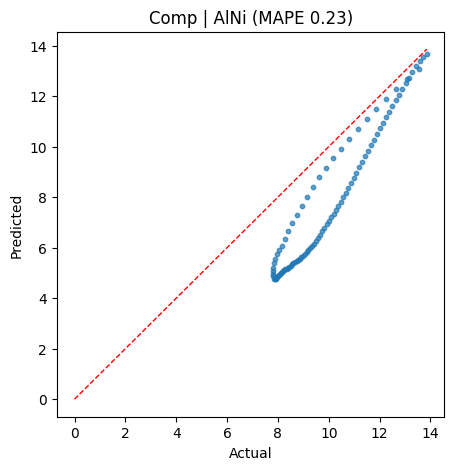

[Comp] Left-out: AlNi | Test MAPE: 0.2317
[Comp] CuMg | Epoch 10/100  Loss: 1.5963
[Comp] CuMg | Epoch 20/100  Loss: 0.5931
[Comp] CuMg | Epoch 30/100  Loss: 0.2776
[Comp] CuMg | Epoch 40/100  Loss: 0.1255
[Comp] CuMg | Epoch 50/100  Loss: 0.0666
[Comp] CuMg | Epoch 60/100  Loss: 0.0372
[Comp] CuMg | Epoch 70/100  Loss: 0.0242
[Comp] CuMg | Epoch 80/100  Loss: 0.0158
[Comp] CuMg | Epoch 90/100  Loss: 0.0109
[Comp] CuMg | Epoch 100/100  Loss: 0.0078


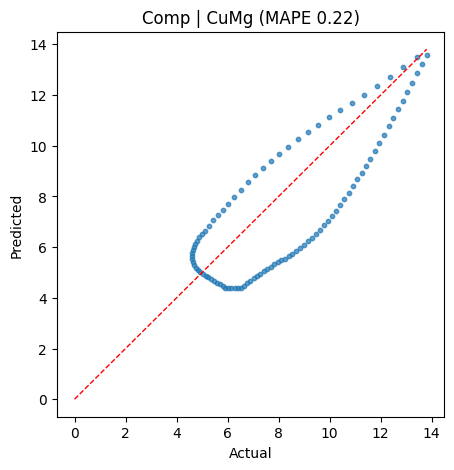

[Comp] Left-out: CuMg | Test MAPE: 0.2156
[Comp] NiMg | Epoch 10/100  Loss: 1.6958
[Comp] NiMg | Epoch 20/100  Loss: 0.6913
[Comp] NiMg | Epoch 30/100  Loss: 0.3050
[Comp] NiMg | Epoch 40/100  Loss: 0.1588
[Comp] NiMg | Epoch 50/100  Loss: 0.0801
[Comp] NiMg | Epoch 60/100  Loss: 0.0471
[Comp] NiMg | Epoch 70/100  Loss: 0.0317
[Comp] NiMg | Epoch 80/100  Loss: 0.0199
[Comp] NiMg | Epoch 90/100  Loss: 0.0142
[Comp] NiMg | Epoch 100/100  Loss: 0.0105


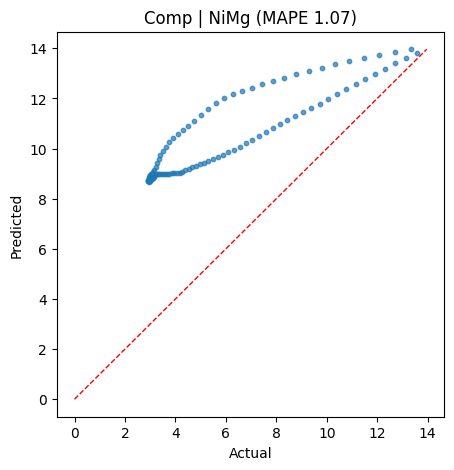

[Comp] Left-out: NiMg | Test MAPE: 1.0736
[Comp] AlTi | Epoch 10/100  Loss: 1.7533
[Comp] AlTi | Epoch 20/100  Loss: 0.8034
[Comp] AlTi | Epoch 30/100  Loss: 0.4500
[Comp] AlTi | Epoch 40/100  Loss: 0.2151
[Comp] AlTi | Epoch 50/100  Loss: 0.1012
[Comp] AlTi | Epoch 60/100  Loss: 0.0495
[Comp] AlTi | Epoch 70/100  Loss: 0.0241
[Comp] AlTi | Epoch 80/100  Loss: 0.0146
[Comp] AlTi | Epoch 90/100  Loss: 0.0099
[Comp] AlTi | Epoch 100/100  Loss: 0.0072


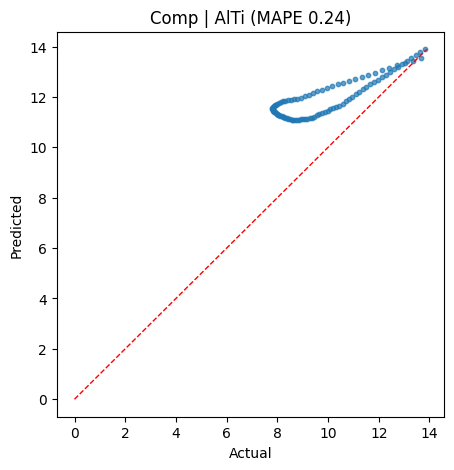

[Comp] Left-out: AlTi | Test MAPE: 0.2397
[Comp] AlV | Epoch 10/100  Loss: 2.0172


KeyboardInterrupt: 

In [36]:
comp_mean_mape, comp_mapes, comp_per_sys = run_loop(df_comp, "Comp", epochs=50, batch_size=32, lr=1e-3)

[Random] AlNi | Epoch 10/100  Loss: 8.6712
[Random] AlNi | Epoch 20/100  Loss: 7.7669
[Random] AlNi | Epoch 30/100  Loss: 7.4050
[Random] AlNi | Epoch 40/100  Loss: 7.2626
[Random] AlNi | Epoch 50/100  Loss: 7.2247
[Random] AlNi | Epoch 60/100  Loss: 7.1724
[Random] AlNi | Epoch 70/100  Loss: 7.1437
[Random] AlNi | Epoch 80/100  Loss: 7.1142
[Random] AlNi | Epoch 90/100  Loss: 7.0663
[Random] AlNi | Epoch 100/100  Loss: 7.0306


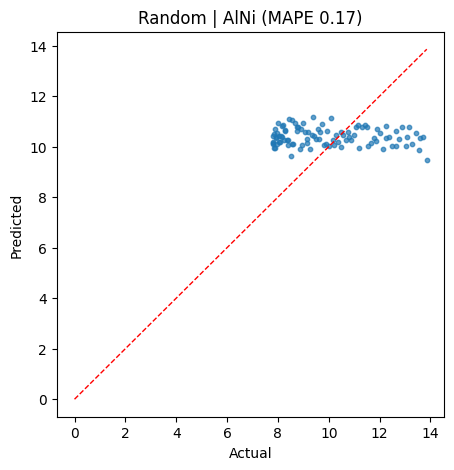

[Random] Left-out: AlNi | Test MAPE: 0.1719
[Random] CuMg | Epoch 10/100  Loss: 8.4227
[Random] CuMg | Epoch 20/100  Loss: 7.7258
[Random] CuMg | Epoch 30/100  Loss: 7.3019
[Random] CuMg | Epoch 40/100  Loss: 7.1487
[Random] CuMg | Epoch 50/100  Loss: 7.1230
[Random] CuMg | Epoch 60/100  Loss: 7.0858
[Random] CuMg | Epoch 70/100  Loss: 7.0432
[Random] CuMg | Epoch 80/100  Loss: 7.0067
[Random] CuMg | Epoch 90/100  Loss: 6.9892
[Random] CuMg | Epoch 100/100  Loss: 6.9569


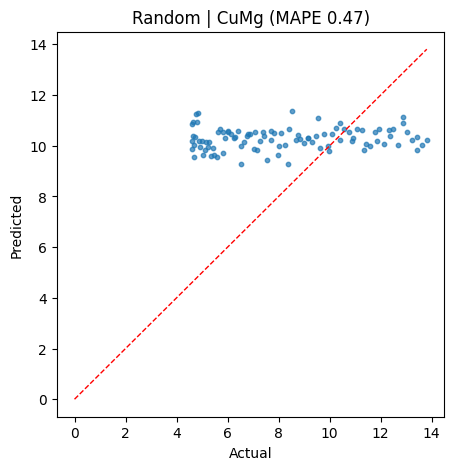

[Random] Left-out: CuMg | Test MAPE: 0.4675
[Random] NiMg | Epoch 10/100  Loss: 8.2236
[Random] NiMg | Epoch 20/100  Loss: 7.4303
[Random] NiMg | Epoch 30/100  Loss: 7.0060


KeyboardInterrupt: 

In [37]:
rand_mean_mape, rand_mapes, rand_per_sys = run_loop(df_rand, "Random", epochs=50, batch_size=32, lr=1e-3)